In [1]:
import gpaw
import ase
import matplotlib.pyplot as plt
import numpy as np
import glob

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [3]:
def get_alchemical_density(calc, lval):
    gridrefinement = 1  # needs to be 1!
    dv = calc.atoms.get_volume() / calc.get_number_of_grid_points().prod()
    
    all_dens = calc.get_all_electron_density(gridrefinement=gridrefinement)
    all_dens *= dv / gridrefinement**3
    pseudo_dens = calc.get_pseudo_density() * dv
    core_dens = all_dens - pseudo_dens
    
    N = all_dens.sum()
    N_core = core_dens.sum()
    N_pseudo = pseudo_dens.sum()
    
    adens = all_dens - lval * core_dens + (N_core * lval) / N_pseudo * pseudo_dens
    return adens

calccache = {}
for folder in glob.glob('data/n2-*/'):
    fn = '%srun.gpaw' % folder
    mixing = folder.split('/')[-2].split('-')[-1]
    calccache[float(mixing)] = gpaw.GPAW(fn, txt=None)

lvals = sorted(calccache.keys())
rhos = np.array([get_alchemical_density(calccache[lval], lval) for lval in lvals])
rhotilde = np.trapz(rhos, lvals, axis=0)
    
calc = calccache[0.0]
pos = calc.atoms.get_positions()
gridpos = calc.density.gd.get_grid_point_coordinates()
xs = gridpos[0].reshape(-1)
ys = gridpos[1].reshape(-1)
zs = gridpos[2].reshape(-1)
gridpos = np.array([xs, ys, zs]).T
rhotilde_reshape = rhotilde.reshape(-1)
for site in range(len(pos)):
    ds = np.linalg.norm(gridpos - pos[site], axis=1)*1.88973
    dE = (rhotilde_reshape*7./ds).sum()
    print (site, dE)


0 3.9129203026585957
1 4.046724481959318


In [19]:
def plot_dens(calc, dens, label=None):
    axis = 2
    gridrefinement = 1  # needs to be 1!
    gridpos = calc.density.gd.get_grid_point_coordinates()
    xs = []
    ys = []
    gridz = sorted(set(gridpos[axis].reshape(-1)))
    for idx in range(len(gridz)):
        xs.append(gridz[idx])
        ys.append(np.sum(dens[np.where(gridpos[axis] == gridz[idx])]))
    plt.plot(xs, ys, label=label)
def get_alchemical_density(calc, lval):
    gridrefinement = 1  # needs to be 1!
    dv = calc.atoms.get_volume() / calc.get_number_of_grid_points().prod()
    
    all_dens = calc.get_all_electron_density(gridrefinement=gridrefinement)
    all_dens *= dv / gridrefinement**3
    pseudo_dens = calc.get_pseudo_density() * dv
    core_dens = pseudo_dens
    valence_dens = all_dens - core_dens
    
    N = all_dens.sum()
    N_core = core_dens.sum()
    N_valence = valence_dens.sum()
    
    adens = all_dens - lval * core_dens + (N_core * lval) / N_pseudo * pseudo_dens
    return adens
#q = get_alchemical_density(calccache[0.0], 1.)
#plot_dens(calc, q)

In [135]:
lvals = sorted(calccache.keys())
rhos = np.array([get_alchemical_density(calccache[lval], lval) for lval in lvals])
rhotilde = np.trapz(rhos, lvals, axis=0)
    
#plot_dens(v, rhotilde)

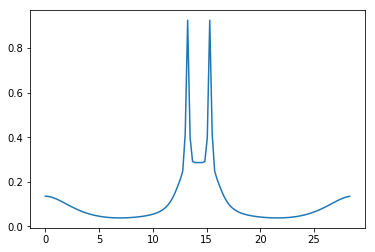

In [136]:
plot_dens(calc, rhotilde)

In [137]:
pos = calc.atoms.get_positions()
gridpos = calc.density.gd.get_grid_point_coordinates()
xs = gridpos[0].reshape(-1)
ys = gridpos[1].reshape(-1)
zs = gridpos[2].reshape(-1)
gridpos = np.array([xs, ys, zs]).T
rhotilde_reshape = rhotilde.reshape(-1)
for site in range(len(pos)):
    ds = np.linalg.norm(gridpos - pos[site], axis=1)*1.88973
    dE = (rhotilde_reshape*7./ds).sum()
    print (site, dE)


0 3.9124818392839043
1 4.046242810270413


In [10]:
def get_energy_cleaned(calc, lval):
    dv = calc.atoms.get_volume() / calc.get_number_of_grid_points().prod()
    
    dens = calc.get_all_electron_density(gridrefinement=gridrefinement) * dv
    
    gridpos = calc.density.gd.get_grid_point_coordinates()
    xs = gridpos[0].reshape(-1)
    ys = gridpos[1].reshape(-1)
    zs = gridpos[2].reshape(-1)
    gridpos = np.array([xs, ys, zs]).T
    rhotilde_reshape = rhotilde.reshape(-1)
    for site in range(len(pos)):
        ds = np.linalg.norm(gridpos - pos[site], axis=1)*1.88973
        dE = (rhotilde_reshape*7./ds).sum()
        print (site, dE)
    
#calccache[1.].results['energy'], calccache[0.].results['energy']

In [3]:
def read_density(mol, lval):
    calc = gpaw.GPAW('data-subset/%s-%s/run.gpaw' % (mol, lval), txt=None)
    return calc, get_alchemical_density(calc, float(lval))

In [4]:
bene = read_density('bene', '0.00')
bf = read_density('bf', '0.00')
co = read_density('co', '0.00')

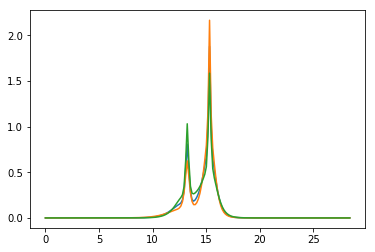

In [5]:
plot_dens(*bf)
plot_dens(*bene)
plot_dens(*co)

In [6]:
benem = read_density('bene', '0.50')
bfm = read_density('bf', '0.50')
com = read_density('co', '0.50')
benef = read_density('bene', '1.00')
bff = read_density('bf', '1.00')
cof = read_density('co', '1.00')

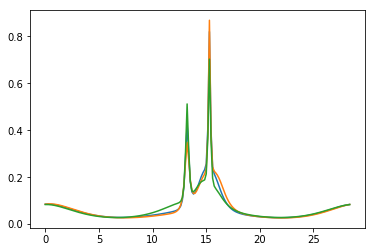

In [7]:
plot_dens(*bfm)
plot_dens(*benem)
plot_dens(*com)

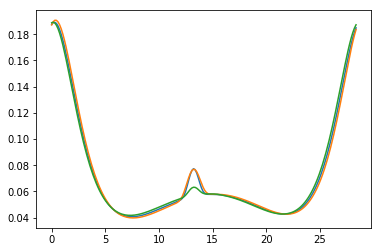

In [8]:
plot_dens(*bff)
plot_dens(*benef)
plot_dens(*cof)

In [9]:
rhotildebf = np.trapz(np.array([bf[1], bfm[1], bff[1]]), (0.0, 0.5,1.), axis=0)
rhotildeco = np.trapz(np.array([co[1], com[1], cof[1]]), (0.0, 0.5,1.), axis=0)
rhotildebene = np.trapz(np.array([bene[1], benem[1], benef[1]]), (0.0, 0.5,1.), axis=0)

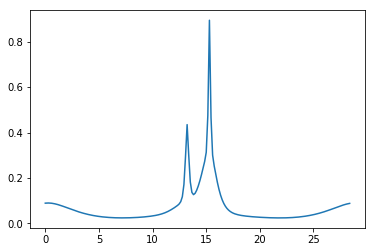

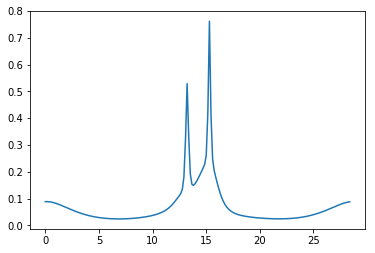

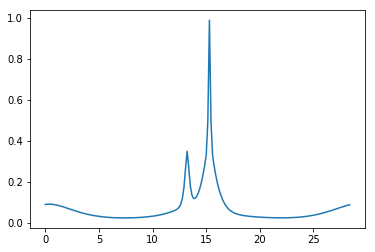

In [10]:
plot_dens(bff[0], rhotildebf)
plt.show()
plot_dens(cof[0], rhotildeco)
plt.show()
plot_dens(benef[0], rhotildebene)

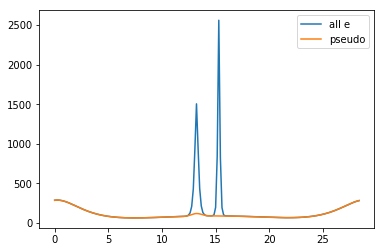

In [18]:
q = bff[0]
plot_dens(q, q.get_all_electron_density(gridrefinement=1), 'all e')
plot_dens(q, q.get_pseudo_density(), 'pseudo')
plt.legend()

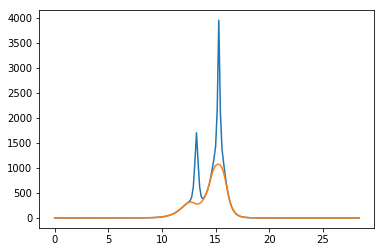

In [16]:
q = bf[0]
plot_dens(q, q.get_all_electron_density(gridrefinement=1))
plot_dens(q, q.get_pseudo_density())